In [ ]:
from getpass import getpass
import os
from dotenv import load_dotenv

# 環境變數
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

In [ ]:
from typing import List
from pydantic import BaseModel

class City(BaseModel):
    # 城市名稱
    name: str
    # 國家
    country: str
    # 人口
    population: int

class CitiesData(BaseModel):
    # 城市列表
    cities: List[City]

In [ ]:
json_schema = CitiesData.schema_json(indent=2)
json_schema

In [5]:
import json
import random
import pydantic
from pydantic import ValidationError
from typing import Optional, List
from colorama import Fore
from haystack import component

# 定義組件的輸入參數
@component
class OutputValidator:
    def __init__(self, pydantic_model: pydantic.BaseModel):
        self.pydantic_model = pydantic_model  # 保存 Pydantic 模型
        self.iteration_counter = 0  # 初始化循環計數器

    # 定義組件的輸出
    @component.output_types(valid_replies=List[str], invalid_replies=Optional[List[str]], error_message=Optional[str])
    def run(self, replies: List[str]):
        self.iteration_counter += 1  # 增加循環計數器

        ## 嘗試解析 LLM 的回覆 ##
        # 如果 LLM 的回覆是一個有效的對象，返回 `"valid_replies"`
        try:
            output_dict = json.loads(replies[0])  # 解析回覆為字典
            self.pydantic_model.parse_obj(output_dict)  # 使用 Pydantic 模型進行驗證
            print(
                Fore.GREEN
                + f"OutputValidator at Iteration {self.iteration_counter}: Valid JSON from LLM - No need for looping: {replies[0]}"
            )
            return {"valid_replies": replies}

        # 如果 LLM 的回覆損壞或無效，返回 "invalid_replies" 和 "error_message" 以便 LLM 重試
        except (ValueError, ValidationError) as e:
            print(
                Fore.RED
                + f"OutputValidator at Iteration {self.iteration_counter}: Invalid JSON from LLM - Let's try again.\n"
                f"Output from LLM:\n {replies[0]} \n"
                f"Error from OutputValidator: {e}"
            )
            return {"invalid_replies": replies, "error_message": str(e)}

In [10]:
output_validator = OutputValidator(pydantic_model=CitiesData)
print(output_validator)

Inputs:
  - replies: List[str]
Outputs:
  - valid_replies: List[str]
  - invalid_replies: Optional[List[str]]
  - error_message: Optional[str]


In [11]:
prompt_template = """
    根據此段落中存在的資訊建立一個 JSON 對象：
    {{passage}}.
    僅使用段落中存在的資訊。
    遵循此 JSON 架構，但僅傳回實際實例，無需任何其他架構定義：
    {{schema}}
    確保您的答案是字典而不是列表。
    {% if invalid_replies and error_message %}
    您在先前的嘗試中已經建立了以下輸出：
    {{invalid_replies}}
    但是，這不符合上面的格式要求並觸發了此 Python 異常：
    {{error_message}}
    更正輸出並重試。只需返回正確的輸出，無需任何額外的解釋。
    {% endif %}
"""

In [12]:
from haystack.components.builders import PromptBuilder

prompt_builder = PromptBuilder(template=prompt_template)

In [13]:
from haystack.components.generators import OpenAIGenerator

# 初始化 OpenAI 生成器
generator = OpenAIGenerator(model="gpt-4-turbo")

In [14]:
from haystack import Pipeline

pipeline = Pipeline(max_loops_allowed=5)

In [15]:
# 添加組件到管道
pipeline.add_component(
    instance=prompt_builder, name="prompt_builder"
)
pipeline.add_component(
    instance=generator, name="llm"
)
pipeline.add_component(
    instance=output_validator, name="output_validator"
)

In [16]:
# 現在，將組件之間進行連接
pipeline.connect(
    "prompt_builder", "llm"
)
pipeline.connect(
    "llm", "output_validator"
)
# 如果一個組件有多個輸出或輸入，請明確指定連接：
pipeline.connect(
    "output_validator.invalid_replies",
    "prompt_builder.invalid_replies"
)
pipeline.connect(
    "output_validator.error_message",
    "prompt_builder.error_message"
)

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - output_validator: OutputValidator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> output_validator.replies (List[str])
  - output_validator.invalid_replies -> prompt_builder.invalid_replies (Optional[List[str]])
  - output_validator.error_message -> prompt_builder.error_message (Optional[str])

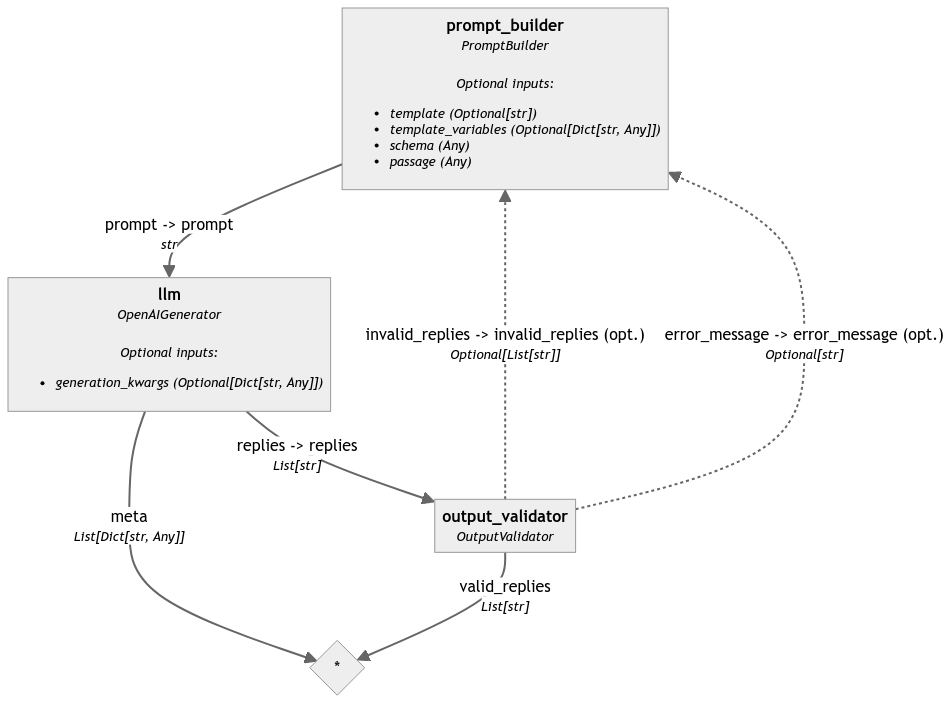

In [17]:
pipeline.draw("auto-correct-pipeline.png")
from utils.draw_pipeline import draw_and_display

draw_and_display(pipeline, "ex08_1_pipe.png")

In [18]:
passage = "柏林是德國的首都。人口3,850,809。法國首都巴黎，居民216.1萬。里斯本是葡萄牙首都和最大城市，人口 504,718 人。"

In [19]:
result = pipeline.run({
    "prompt_builder": {
        "passage": passage,
        "schema": json_schema
    }
})

OutputValidator at Iteration 1: Valid JSON from LLM - No need for looping: {
  "cities": [
    {
      "name": "柏林",
      "country": "德國",
      "population": 3850809
    },
    {
      "name": "巴黎",
      "country": "法國",
      "population": 2161000
    },
    {
      "name": "里斯本",
      "country": "葡萄牙",
      "population": 504718
    }
  ]
}


In [20]:
valid_reply = result["output_validator"]["valid_replies"][0]
valid_json = json.loads(valid_reply)
print(valid_json)

{'cities': [{'name': '柏林', 'country': '德國', 'population': 3850809}, {'name': '巴黎', 'country': '法國', 'population': 2161000}, {'name': '里斯本', 'country': '葡萄牙', 'population': 504718}]}
